# Thermal stability of hundreds of point mutants of a family 1 glycoside hydrolase 

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
from scipy.optimize import curve_fit 
from numpy import log, exp, linspace, sqrt, diag
from sklearn.linear_model import LinearRegression
import os
import re 

df = pandas.read_csv( 'data/Bagel Thermostability - cleaned_data.csv' )
raw = len( df )
df.index = df.mutant
df.drop( 'mutant', inplace=True )
df.drop( ['WT', 'WT1'], inplace=True )
df.dropna( inplace=True ) 

with open( 'data/allowed_mutants.txt' ) as fn:
    mutants = [ i.split('.')[0].upper() for i in fn.readlines() if len( i ) > 1 ]
    
def is_good( name ):
    return name in mutants 

# this is a sanity-checking routine for "off-by-threes"
not_allowed = []
l = []
for name in df.index:
    #print name
    if is_good( name ):
        l.append( name )
    else:
        new = name[0] + str( int( re.findall( r'\d+', name )[0] ) - 3 ) + name[-1]
        if is_good( new ):
            l.append( new )
        else:
            l.append( 'drop_me' )
            not_allowed.append( name )
            
df.index = l
df.drop( ['drop_me'], inplace=True )

# temperature keys as CSV files in data/
temp_key = pandas.read_csv( 'data/temp_key.csv' )
temp_key.index = temp_key.Well
df['temp'] = df.well.str[0].map( temp_key.Celsius.to_dict() ) 
df.dropna( inplace=True )
df.sample( 10 )
print '{} individual rates will be used (dropped {})'.format( len( df ), raw - len( df ) )
print 'Dropped samples {} because the given native residue does not match the BglB sequence'.format( set( not_allowed ) )

3145 individual rates will be used (dropped 168)
Dropped samples set(['E17S', 'E53A', 'Q384R', 'W299A']) because the given native residue does not match the BglB sequence


# Curve fit to logistic equation

In [7]:
# logistic equation 
def f(x, x0, k): 
    return 1/(1+exp(-k*(x-x0)))

# util function to fit a mutant 
def fit( df ):
    name = df.mutant.unique()[0]
    df.rate = df.rate / df.rate.max()
    
    # linear fit 
    reg = LinearRegression()
    reg.fit( df.temp.reshape(-1, 1), df.rate )
    slope = reg.coef_[0]
    
    # try fitting to logistic eqn 
    try:
        p0 = ( df.temp.mean(), slope )
        popt, pcov = curve_fit( f, df.temp, df.rate, p0=p0 )
        perr = sqrt( diag( pcov ) ) 
        if 30 < popt[0] < 50: # biological assay limits 
            return pandas.Series( popt, index=['tm', 'k'] )
        else:
            #iffy += [ name ]
            raise Exception( 'Warning: dropping fit for {0} because Tm of {1:2.2f} is outside range 30-50 C'.format( name, popt[0] ) )
    except Exception as e:
        print e
    
grouped = df.groupby( by='mutant' )
fits = grouped.apply( fit )
print ''
print 'Successfully fit {} of {} samples to the logistic equation'.format( len( fits ), len( grouped ) )


Successfully fit 119 of 119 samples to the logistic equation


In [8]:
fits

,tm,k
mutant,,
A195S,39.100764,-0.931507
A356A,39.886138,-1.122859
A357A,39.113754,-0.326374
A408A,39.958372,-1.263093
C167A,39.736959,-1.389863
C167Q,38.474155,-0.533021
D403A,NaN,NaN
E154D,38.685433,-0.694348
E164A,NaN,NaN


## Diagnostic plots to help determine goodness of fits

In [9]:
!mkdir plots 
for index, df in grouped:
    name = df.mutant.unique()[0]
    rate = df.rate / df.rate.max() # have to do this again
    plt.figure( figsize=(2,2) )
    plt.scatter( df.temp, rate, alpha=0.7, color='black', marker='.' )
    popt = fits.loc[ name ]
    if popt is not None:
        x_space = linspace( df.temp.min(), df.temp.max(), 100 )
        plt.plot( x_space, f( x_space, *popt ), alpha=0.5, color='purple' )
    plt.xlabel( 'T (C)' )
    plt.ylabel( 'Normalized rate')
    plt.xticks( [ 30, 40, 50 ] )
    plt.yticks( [ 0, 0.5, 1 ] )
    plt.title( name )
    plt.tight_layout()
    plt.savefig( 'plots/%s.pdf' % name, format='pdf' )
    #plt.show()
    plt.close()

mkdir: cannot create directory ‘plots’: File exists


## Clean up and apply what we learned from the plots to the data set 

In [10]:
# nothing here, yet! 

In [11]:
# add metadata
fits['native'] = fits.index.str[0]
fits['designed'] = fits.index.str[-1]
fits['position'] = fits.index.str[1:-1].astype( int )
fits.sample( 10 )

,tm,k,native,designed,position
mutant,,,,,
N163A,40.764759,-0.417117,N,A,163
S14A,40.025318,-1.572317,S,A,14
Q313R,42.111481,-1.205015,Q,R,313
T178R,NaN,NaN,T,R,178
M361T,39.492677,-1.440905,M,T,361
N163C,37.700445,-0.338536,N,C,163
E222R,39.041495,-0.827561,E,R,222
G355A,NaN,NaN,G,A,355
P329N,NaN,NaN,P,N,329


In [12]:
# makes resfiles for DDG Rosetta app 
!mkdir ddg/resfiles 

for ( index, series ) in fits.iterrows():
    with open( 'ddg/resfiles/{}'.format( index ), 'w' ) as fn:
        fn.write( 'NATRO\nSTART\n{} A PIKAA {}'.format( series.position, series.designed ) )

mkdir: cannot create directory ‘ddg/resfiles’: File exists


In [13]:
%%bash 

ls ddg/resfiles > ddg/list
NUM=$( wc -l ddg/list | cut -d' ' -f1 )
cd ddg && sbatch --array=1-${NUM} sub.sh 

Submitted batch job 147612


In [14]:
!ls ddg/

bglb.pdb		mut_I195S_round_18.pdb	mut_S14A_round_12.pdb
flags			mut_I195S_round_19.pdb	mut_S14A_round_13.pdb
list			mut_I195S_round_1.pdb	mut_S14A_round_14.pdb
log.txt			mut_I195S_round_20.pdb	mut_S14A_round_15.pdb
mutant_trajC167A	mut_I195S_round_21.pdb	mut_S14A_round_16.pdb
mutant_trajC167Q	mut_I195S_round_22.pdb	mut_S14A_round_17.pdb
mutant_trajD403A	mut_I195S_round_23.pdb	mut_S14A_round_18.pdb
mutant_trajD55G		mut_I195S_round_24.pdb	mut_S14A_round_19.pdb
mutant_trajE154D	mut_I195S_round_25.pdb	mut_S14A_round_1.pdb
mutant_trajE164A	mut_I195S_round_26.pdb	mut_S14A_round_20.pdb
mutant_trajE164G	mut_I195S_round_27.pdb	mut_S14A_round_21.pdb
mutant_trajE164R	mut_I195S_round_28.pdb	mut_S14A_round_22.pdb
mutant_trajE177A	mut_I195S_round_29.pdb	mut_S14A_round_23.pdb
mutant_trajE222A	mut_I195S_round_2.pdb	mut_S14A_round_24.pdb
mutant_trajE222H	mut_I195S_round_30.pdb	mut_S14A_round_25.pdb
mutant_trajE222K	mut_I195S_round_31.pdb	mut_S14A_round_26.pdb
mutant_trajE222Q	mut_I195S_round_3.pdb	mut_S

## Comparison between Rosetta `ddg_monomer` app and experimental results

In [18]:
! ( head -1 ddg/ddg_predictions.out && grep -v desc ddg/ddg_predictions.out ) > ddg/readable_output

In [20]:
preds = pandas.read_csv( 'ddg/readable_output', sep='\s+' )
preds.index = preds.description.values
joined = preds.join( fits )
joined.sample( 10 )

,ddG:,description,total,fa_atr,fa_rep,fa_sol,fa_intra_rep,fa_elec,pro_close,hbond_sr_bb,...,fa_dun,p_aa_pp,ref,chainbreak,res_type_constraint,tm,k,native,designed,position
D403A,ddG:,D403A,1.560,9.085,0.102,-15.033,-0.032,8.041,0.013,0.194,...,-4.709,0.332,1.880,0,0,NaN,NaN,D,A,403
E222R,ddG:,E222R,-2.747,-4.150,0.520,4.238,0.018,-3.760,0.017,0.427,...,1.965,0.034,1.405,0,0,39.041495,-0.827561,E,R,222
Q19A,ddG:,Q19A,1.286,7.382,-0.700,-5.518,-0.010,0.535,0.001,0.308,...,-2.886,-0.207,1.771,0,0,NaN,NaN,Q,A,19
K334A,ddG:,K334A,0.338,-2.348,0.632,2.830,0.003,-2.074,0.007,-0.082,...,1.146,-0.128,0.880,0,0,NaN,NaN,NaN,NaN,NaN
W409Y,ddG:,W409Y,1.101,2.892,1.832,-0.618,0.009,-1.151,-0.025,-0.030,...,0.874,-0.083,-0.798,0,0,42.388926,-2.582311,W,Y,409
E406A,ddG:,E406A,1.465,1.366,-1.147,-4.632,-0.001,3.575,-0.038,-0.099,...,-2.004,0.380,2.147,0,0,39.934139,-1.524576,E,A,406
W325G,ddG:,W325G,7.438,15.633,2.519,-9.696,0.084,0.902,-0.091,0.186,...,-8.156,0.783,-0.789,0,0,NaN,NaN,W,G,325
Y18A,ddG:,Y18A,4.651,11.447,-0.327,-6.049,-0.018,0.727,0.026,-0.658,...,-3.656,-0.326,0.461,0,0,37.193482,-0.348477,Y,A,18
P329N,ddG:,P329N,3.537,2.321,-0.903,-2.334,-0.019,3.267,-0.124,-0.026,...,-0.535,0.202,-0.723,0,0,NaN,NaN,P,N,329
M323K,ddG:,M323K,3.428,-0.968,0.955,6.073,0.019,-2.230,-0.010,-0.493,...,1.083,-0.441,-0.446,0,0,38.608623,-1.066339,M,K,323


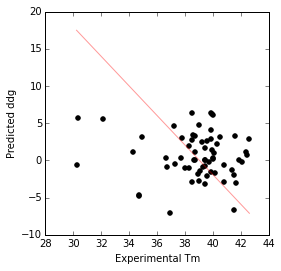

In [21]:
plt.figure( figsize=( 4, 4 ) )
plt.scatter( joined.tm, joined.total, color='k' )
plt.plot( ( joined.tm.min(), joined.tm.max() ), ( joined.total.max() , joined.total.min() ), color='red', alpha=0.4 ) #perfect correlation
plt.xlabel( 'Experimental Tm' )
plt.ylabel( 'Predicted ddg' )